In [44]:
%load_ext autoreload
%autoreload 2
import numpy as np
import nibabel as nib
from modalities.nifti_image import NiftiImage

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


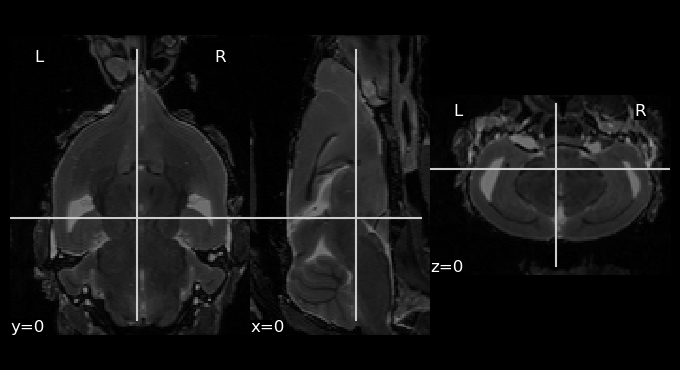

In [45]:
nifti_image = NiftiImage('data/_archive/Yagishita_Sharapova_20240205_HF4_G4_8_5_1.nii')
nifti_image.plot_with_crosshair([62.7, 95, 35.8])

In [46]:
# print("Raw Image Data:", nifti_image.image_data)

In [47]:
alignment_params = np.array([
    0,    # X translation
    0,    # Y translation
    0,    # Z translation
    1.7,  # X rotation (pitch)
    0,    # Y rotation (roll)
    0,    # Z rotation (yaw)
    10,   # X scaling
    10,   # Y scaling
    10,   # Z scaling
    0,    # X affine
    0,    # Y affine
    0     # Z affine
])

In [48]:
nifti_image.update_affine_matrix(alignment_params)

In [49]:
nifti_image.save('rotated.nii')

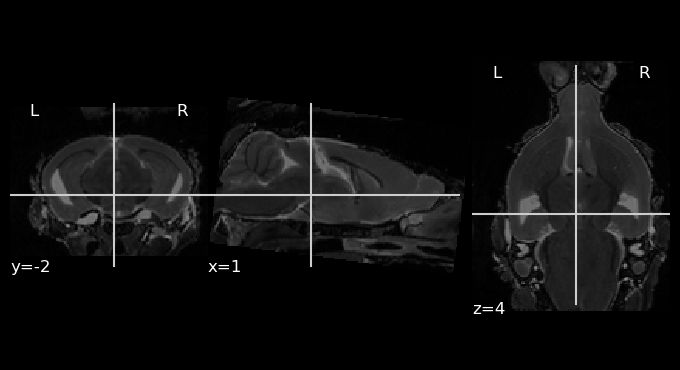

In [50]:
crosshair_position = [62.7, 95, 35.8]
nifti_image.plot_with_crosshair(crosshair_position)

In [31]:
# getting params from template image to reorient all images accordingly
template = nib.load('AverageT2.nii')
template.affine

FileNotFoundError: No such file or no access: 'AverageT2.nii'

# testing new logic

In [ ]:
nifti_image = NiftiImage('data/_archive/Yagishita_Sharapova_20240207_HF4_G5_11_3_1.nii')
image_data = nifti_image.image_data
print("Image Data Shape:", image_data.shape)

Image Data Shape: (128, 160, 96)


In [ ]:
alignment_params = np.array([
    -2.9204,    # X translation
    -24.6918,    # Y translation
    -39.0698,    # Z translation
    np.pi * 0.5,  # X rotation (pitch)
    0,    # Y rotation (roll)
    0,    # Z rotation (yaw)
    10,   # X scaling
    10,   # Y scaling
    10,   # Z scaling
    0,    # X affine
    0,    # Y affine
    0     # Z affine
])

nifti_image.update_affine_matrix(alignment_params)

In [ ]:
nifti_image.save('updated_image_file.nii')

In [ ]:
def find_origin_voxel(image_file_path):
    """
    Find the voxel coordinates of the origin (0, 0, 0) in the world coordinates for a NIfTI image.
    :param image_file_path: Path to the NIfTI image file.
    :return: Voxel coordinates of the origin.
    """
    img = nib.load(image_file_path)
    affine = img.affine
    
    qform = img.get_qform()
    sform = img.get_sform()
    print("Q-form matrix:\n", qform)
    print("S-form matrix:\n", sform)

    
    affine_inv = np.linalg.inv(affine) # Invert the affine matrix
    world_origin = np.array([0, 0, 0, 1]) # World origin in homogeneous coordinates 
    voxel_origin = np.dot(affine_inv, world_origin)[:3] # Find the voxel coordinates corresponding to the world origin

    return voxel_origin

voxel_origin = find_origin_voxel('data/AverageT2.nii')
print("Voxel coordinates of the origin:", voxel_origin)

Q-form matrix:
 [[ -1.   0.   0.  55.]
 [  0.   1.   0. -95.]
 [  0.   0.   1. -75.]
 [  0.   0.   0.   1.]]
S-form matrix:
 [[ -1.   0.   0.  55.]
 [  0.   1.   0. -95.]
 [  0.   0.   1. -75.]
 [  0.   0.   0.   1.]]
Voxel coordinates of the origin: [55. 95. 75.]


In [ ]:
def find_origin_voxel(image_file_path):
    """
    Find the voxel coordinates of the origin (0, 0, 0) in the world coordinates for a NIfTI image.
    :param image_file_path: Path to the NIfTI image file.
    :return: Voxel coordinates of the origin.
    """
    img = nib.load(image_file_path)
    affine = img.affine

    qform = img.get_qform()
    sform = img.get_sform()
    print("Q-form matrix:\n", qform)
    print("S-form matrix:\n", sform)

    affine_inv = np.linalg.inv(affine)  # Invert the affine matrix
 
    world_origin = np.array([0, 0, 0, 1]) # World origin in homogeneous coordinates

    voxel_origin = np.dot(affine_inv, world_origin)[:3] # Find the voxel coordinates corresponding to the world origin

    return voxel_origin

voxel_origin = find_origin_voxel('updated_image_file.nii')
print("Voxel coordinates of the origin:", voxel_origin)

Q-form matrix:
 [[-1.00000000e+00  0.00000000e+00  0.00000000e+00  5.73741264e+01]
 [ 0.00000000e+00 -1.00000000e+00 -4.44089210e-16  5.95837402e+01]
 [ 0.00000000e+00 -4.44089210e-16  1.00000000e+00 -7.56434021e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
S-form matrix:
 [[-1.00000000e+00 -3.06161713e-17  3.06161713e-17  5.73741264e+01]
 [ 3.06161713e-17 -1.00000000e+00 -6.12323426e-17  5.95837402e+01]
 [ 3.06161713e-17 -6.12323426e-17  1.00000000e+00 -7.56434021e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Voxel coordinates of the origin: [57.37412643 59.58374023 75.6434021 ]


# new logic function is working and rotating correctly

In [36]:
# works ok
import math
import numpy as np
import matplotlib.pyplot as plt
from nibabel import load, save, Nifti1Image
from nilearn.plotting import plot_anat

class NiftiImage:
    """
    Handle a NIfTI1-format image data.
    """

    def __init__(self, image_file_path: str):
        """
        [arguments]
        file_path: NIfTI1-format image file path.
        """
        self.image_file_path = image_file_path

        # Create the NIfTI image object from the file.
        self.img = load(image_file_path)
        self.original_affine = self.img.affine.copy()  # Save the original affine matrix for comparison

    @property
    def image_data(self):
        """
        Return the raw image data without affine transformation.
        """
        return self.img.get_fdata()

    def update_affine_matrix(self, alignment_params, save_file_path: str = None):
        """
        Calculate a new affine transformation matrix with alignment parameters,
        and update the NIfTI image object with the matrix.
        """
        # Calculate a new affine transformation matrix.
        current_matrix = self.__create_affine_matrix_from_params(alignment_params)
        new_affine_matrix = np.dot(current_matrix, self.img.affine)

        # Debug: Print the new affine matrix
        print("New Affine Matrix:\n", new_affine_matrix)

        # Update the NIfTI image object with the new matrix.
        self.img = Nifti1Image(self.img.get_fdata(), new_affine_matrix, self.img.header)

    def __create_affine_matrix_from_params(self, params):
        """
        Create an affine transformation matrix from the following alignment parameters:
          0: X translation
          1: Y translation
          2: Z translation
          3: X rotation (pitch (radians))
          4: Y rotation (roll (radians))
          5: Z rotation (yaw (radians))
          6: X scaling
          7: Y scaling
          8: Z scaling
          9: X affine
          10: Y affine
          11: Z affine.
        The implementation is based on the spm_matrix() function of SPM12.
        """

        translation_matrix = np.array([[1, 0, 0, params[0]],
                                       [0, 1, 0, params[1]],
                                       [0, 0, 1, params[2]],
                                       [0, 0, 0, 1]])

        # Create the rotation matrix.
        rotation_matrix_1 = np.array([[1, 0, 0, 0],
                                      [0, math.cos(params[3]), math.sin(params[3]), 0],
                                      [0, -math.sin(params[3]), math.cos(params[3]), 0],
                                      [0, 0, 0, 1]])

        rotation_matrix_2 = np.array([[math.cos(params[4]), 0, math.sin(params[4]), 0],
                                      [0, 1, 0, 0],
                                      [-math.sin(params[4]), 0, math.cos(params[4]), 0],
                                      [0, 0, 0, 1]])

        rotation_matrix_3 = np.array([[math.cos(params[5]), math.sin(params[5]), 0, 0],
                                      [-math.sin(params[5]), math.cos(params[5]), 0, 0],
                                      [0, 0, 1, 0],
                                      [0, 0, 0, 1]])

        rotation_matrix = rotation_matrix_1 @ rotation_matrix_2 @ rotation_matrix_3

        scaling_matrix = np.array([[params[6], 0, 0, 0],
                                   [0, params[7], 0, 0],
                                   [0, 0, params[8], 0],
                                   [0, 0, 0, 1]])

        shear_matrix = np.array([[1, params[9], params[10], 0],
                                 [0, 1, params[11], 0],
                                 [0, 0, 1, 0],
                                 [0, 0, 0, 1]])

        affine_matrix = translation_matrix @ rotation_matrix @ scaling_matrix @ shear_matrix

        return affine_matrix

    def save(self, save_file_path: str = None):
        """
        Save the NIfTI image object to a file.
        """

        # Overwrite the NIfTI file if save_file_path is not specified.
        if save_file_path is None:
            save_file_path = self.image_file_path

        save(self.img, save_file_path)

        # Debug: Confirm the file was saved
        print(f"File saved to {save_file_path}")

# Example usage
if __name__ == "__main__":
    # Load an image
    nifti_image = NiftiImage('data/_archive/Yagishita_Sharapova_20240205_HF4_G4_8_5_1.nii')

    # Define transformation parameters
    params = [0, 0, 0, 1.7, 0, 0, 10, 10, 10, 0, 0, 0]

    # Update affine matrix
    nifti_image.update_affine_matrix(params)

    # Save the image
    nifti_image.save('path_to_output_image.nii')


New Affine Matrix:
 [[-1.00000001e+00 -3.06161711e-17  3.06161711e-17  6.13396692e+01]
 [ 3.43057046e-17 -9.91664825e-01  1.28844496e-01  8.87024814e+01]
 [ 2.64162544e-17  1.28844496e-01  9.91664825e-01 -4.64852912e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
File saved to path_to_output_image.nii


In [42]:
# works ok

import math
import numpy as np
from nibabel import load, save, Nifti1Image

class NiftiImage:
    """
    Handle a NIfTI1-format image data.
    """

    def __init__(self, image_file_path: str):
        """
        [arguments]
        file_path: NIfTI1-format image file path.
        """
        self.image_file_path = image_file_path

        # Create the NIfTI image object from the file.
        self.img = load(image_file_path)
        self.original_affine = self.img.affine.copy()  # Save the original affine matrix for comparison

    @property
    def image_data(self):
        """
        Return the raw image data without affine transformation.
        """
        return self.img.get_fdata()

    def update_affine_matrix(self, alignment_params, save_file_path: str = None):
        """
        Calculate a new affine transformation matrix with alignment parameters,
        and update the NIfTI image object with the matrix.
        """
        # Calculate a new affine transformation matrix.
        current_matrix = self.__create_affine_matrix_from_params(alignment_params)
        new_affine_matrix = np.dot(current_matrix, self.img.affine)

        # Debug: Print the new affine matrix
        print("New Affine Matrix:\n", new_affine_matrix)

        # Update the NIfTI image object with the new matrix.
        self.img = Nifti1Image(self.img.get_fdata(), new_affine_matrix, self.img.header)

    def __create_affine_matrix_from_params(self, params):
        """
        Create an affine transformation matrix from the following alignment parameters:
          0: X translation
          1: Y translation
          2: Z translation
          3: X rotation (pitch (radians))
          4: Y rotation (roll (radians))
          5: Z rotation (yaw (radians))
          6: X scaling
          7: Y scaling
          8: Z scaling
          9: X affine
          10: Y affine
          11: Z affine.
        The implementation is based on the spm_matrix() function of SPM12.
        """

        translation_matrix = np.array([[1, 0, 0, params[0]],
                                       [0, 1, 0, params[1]],
                                       [0, 0, 1, params[2]],
                                       [0, 0, 0, 1]])

        # Create the rotation matrix.
        rotation_matrix_1 = np.array([[1, 0, 0, 0],
                                      [0, math.cos(params[3]), math.sin(params[3]), 0],
                                      [0, -math.sin(params[3]), math.cos(params[3]), 0],
                                      [0, 0, 0, 1]])

        rotation_matrix_2 = np.array([[math.cos(params[4]), 0, math.sin(params[4]), 0],
                                      [0, 1, 0, 0],
                                      [-math.sin(params[4]), 0, math.cos(params[4]), 0],
                                      [0, 0, 0, 1]])

        rotation_matrix_3 = np.array([[math.cos(params[5]), math.sin(params[5]), 0, 0],
                                      [-math.sin(params[5]), math.cos(params[5]), 0, 0],
                                      [0, 0, 1, 0],
                                      [0, 0, 0, 1]])

        rotation_matrix = rotation_matrix_1 @ rotation_matrix_2 @ rotation_matrix_3

        scaling_matrix = np.array([[params[6], 0, 0, 0],
                                   [0, params[7], 0, 0],
                                   [0, 0, params[8], 0],
                                   [0, 0, 0, 1]])

        shear_matrix = np.array([[1, params[9], params[10], 0],
                                 [0, 1, params[11], 0],
                                 [0, 0, 1, 0],
                                 [0, 0, 0, 1]])

        affine_matrix = translation_matrix @ rotation_matrix @ scaling_matrix @ shear_matrix

        return affine_matrix

    def set_crosshair_position(self, new_crosshair_mm, save_file_path: str = None):
        """
        Set the crosshair position by adjusting the affine matrix.
        [arguments]
        new_crosshair_mm: Tuple of (x, y, z) coordinates in mm where the crosshair should be.
        save_file_path: Optional; the path to save the updated NIfTI file.
        """
        # Calculate the current crosshair position in voxel space.
        new_crosshair_vox = np.linalg.inv(self.img.affine).dot(np.append(new_crosshair_mm, 1))[:3]

        # Calculate the translation to move the crosshair to the origin (0, 0, 0) in voxel space.
        translation_to_origin = -new_crosshair_vox

        # Create a translation matrix to apply this translation.
        translation_matrix = np.eye(4)
        translation_matrix[:3, 3] = translation_to_origin

        # Apply this translation to the affine matrix.
        new_affine_matrix = self.img.affine @ translation_matrix

        # Update the NIfTI image object with the new affine matrix.
        self.img = Nifti1Image(self.img.get_fdata(), new_affine_matrix, self.img.header)

        # Save the updated NIfTI image if a save path is provided.
        if save_file_path:
            save(self.img, save_file_path)
            print(f"File saved to {save_file_path}")

# Example usage
if __name__ == "__main__":
    # Load an image
    nifti_image = NiftiImage('data/_archive/Yagishita_Sharapova_20240205_HF4_G4_8_5_1.nii')

    # Define transformation parameters
    params = [0, 0, 0, 1.7, 0, 0, 10, 10, 10, 0, 0, 0]

    # Update affine matrix
    nifti_image.update_affine_matrix(params)

    # Save the image
    new_crosshair_mm = (59.9, 73.9, 78.0)
    nifti_image.set_crosshair_position(new_crosshair_mm, 'path_to_output_image_with_crosshair_v3.nii')

New Affine Matrix:
 [[-1.00000001e+00 -3.06161711e-17  3.06161711e-17  6.13396692e+01]
 [ 3.43057046e-17 -9.91664825e-01  1.28844496e-01  8.87024814e+01]
 [ 2.64162544e-17  1.28844496e-01  9.91664825e-01 -4.64852912e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
File saved to path_to_output_image_with_crosshair_v3.nii


In [10]:
# test is working well!

import numpy as np
from nibabel import load, save, Nifti1Image

class NiftiImage:
    """
    Handle a NIfTI1-format image data.
    """

    def __init__(self, image_file_path: str):
        """
        [arguments]
        file_path: NIfTI1-format image file path.
        """
        self.image_file_path = image_file_path

        # Create the NIfTI image object from the file.
        self.img = load(image_file_path)
        self.original_affine = self.img.affine.copy()  # Save the original affine matrix for comparison

    @property
    def image_data(self):
        """
        Return the raw image data without affine transformation.
        """
        return self.img.get_fdata()

    def update_affine_matrix(self, alignment_params, save_file_path: str = None):
        """
        Calculate a new affine transformation matrix with alignment parameters,
        and update the NIfTI image object with the matrix.
        """
        # Calculate a new affine transformation matrix.
        current_matrix = self.__create_affine_matrix_from_params(alignment_params)
        new_affine_matrix = np.dot(current_matrix, self.img.affine)

        # Debug: Print the new affine matrix
        print("New Affine Matrix:\n", new_affine_matrix)

        # Update the NIfTI image object with the new matrix.
        self.img = Nifti1Image(self.img.get_fdata(), new_affine_matrix, self.img.header)

    def __create_affine_matrix_from_params(self, params):
        """
        Create an affine transformation matrix from the following alignment parameters:
          0: X translation
          1: Y translation
          2: Z translation
          3: X rotation (pitch (radians))
          4: Y rotation (roll (radians))
          5: Z rotation (yaw (radians))
          6: X scaling
          7: Y scaling
          8: Z scaling
          9: X affine
          10: Y affine
          11: Z affine.
        The implementation is based on the spm_matrix() function of SPM12.
        """

        translation_matrix = np.array([[1, 0, 0, params[0]],
                                       [0, 1, 0, params[1]],
                                       [0, 0, 1, params[2]],
                                       [0, 0, 0, 1]])

        # Create the rotation matrix.
        rotation_matrix_1 = np.array([[1, 0, 0, 0],
                                      [0, np.cos(params[3]), np.sin(params[3]), 0],
                                      [0, -np.sin(params[3]), np.cos(params[3]), 0],
                                      [0, 0, 0, 1]])

        rotation_matrix_2 = np.array([[np.cos(params[4]), 0, np.sin(params[4]), 0],
                                      [0, 1, 0, 0],
                                      [-np.sin(params[4]), 0, np.cos(params[4]), 0],
                                      [0, 0, 0, 1]])

        rotation_matrix_3 = np.array([[np.cos(params[5]), np.sin(params[5]), 0, 0],
                                      [-np.sin(params[5]), np.cos(params[5]), 0, 0],
                                      [0, 0, 1, 0],
                                      [0, 0, 0, 1]])

        rotation_matrix = rotation_matrix_1 @ rotation_matrix_2 @ rotation_matrix_3

        scaling_matrix = np.array([[params[6], 0, 0, 0],
                                   [0, params[7], 0, 0],
                                   [0, 0, params[8], 0],
                                   [0, 0, 0, 1]])

        shear_matrix = np.array([[1, params[9], params[10], 0],
                                 [0, 1, params[11], 0],
                                 [0, 0, 1, 0],
                                 [0, 0, 0, 1]])

        affine_matrix = translation_matrix @ rotation_matrix @ scaling_matrix @ shear_matrix

        return affine_matrix

    def set_crosshair_position(self, new_crosshair_mm, save_file_path: str = None):
        """
        Set the crosshair position by adjusting the affine matrix.
        [arguments]
        new_crosshair_mm: Tuple of (x, y, z) coordinates in mm where the crosshair should be.
        save_file_path: Optional; the path to save the updated NIfTI file.
        """
        # Calculate the current position of the crosshair in voxel space
        new_crosshair_vox = np.linalg.inv(self.img.affine).dot(np.append(new_crosshair_mm, 1))[:3]

        # Calculate the translation to move the crosshair to the origin (0, 0, 0) in real-world coordinates
        current_position_mm = self.img.affine.dot(np.append(new_crosshair_vox, 1))[:3]

        # Calculate the translation needed to move this point to the origin
        translation_to_origin = -current_position_mm

        # Create a translation matrix
        translation_matrix = np.eye(4)
        translation_matrix[:3, 3] = translation_to_origin

        # Apply this translation to the original affine matrix
        new_affine_matrix = translation_matrix @ self.img.affine

        # Update the NIfTI image object with the new affine matrix
        self.img = Nifti1Image(self.img.get_fdata(), new_affine_matrix, self.img.header)

        # Save the updated NIfTI image if a save path is provided
        if save_file_path:
            save(self.img, save_file_path)
            print(f"File saved to {save_file_path}")

# Example usage
if __name__ == "__main__":
    # Load an image
    nifti_image = NiftiImage('data/analysis/control_analysis - Copy/T2_223/T2_223.nii')

    # Define transformation parameters
    params = [0, 0, 0, 1.7, 0, 0, 10, 10, 10, 0, 0, 0]

    # Update affine matrix
    nifti_image.update_affine_matrix(params)

    # Set the crosshair position
    # new_crosshair_mm = (8, 20, 40) # in SPM 54.3 80.3 77.9
    new_crosshair_mm = (-10, 30, 45) # in SPM 52.3 82.3 77.7
    nifti_image.set_crosshair_position(new_crosshair_mm, 'crosshair_4_24_39.nii')


New Affine Matrix:
 [[ 1.00000001e+00 -1.04794687e-24 -6.12323412e-17 -6.82654095e+01]
 [-7.88944899e-18 -9.91664830e-01 -1.28844462e-01  7.98505532e+01]
 [-6.07219581e-17  1.28844462e-01 -9.91664830e-01  4.51711470e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
File saved to crosshair_4_24_39.nii
